<a href="https://colab.research.google.com/github/ashishpatel26/Covid19-Models/blob/master/Covid19_Multimodel_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 1.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
warnings.filterwarnings("ignore")

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import *
from tensorflow.keras.applications.vgg19 import *
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.data_utils import Sequence
# from keras.utils import Sequence

TensorFlow 1.x selected.


In [0]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

In [0]:
x_train = []
x_test = []
y_train = []
label_map = {"pneumonia":0,"corona":1}

In [0]:
path="/content/drive/My Drive/dataset/train"

In [0]:
from glob import glob
images_per_class = {}
for class_folder_name in os.listdir(path):
    class_folder_path = os.path.join(path, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in tqdm(glob(os.path.join(class_folder_path, "*.jpg"))):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

100%|██████████| 89/89 [00:27<00:00,  3.19it/s]


In [0]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

corona -> 89
pneumonia -> 89


In [0]:
dim = 300

In [0]:
# import numpy as np
# label_map = {"pneumonia":0,"corona":1}
# targets = np.zeros(2)
# targets[label_map['pneumonia']] = 1 
# targets[label_map['corona']] = 1 
# targets

In [0]:
x_train=[]
y_train=[]

In [0]:
dirs = os.listdir(path)
for k in range(len(dirs)):    # Directory
    files = os.listdir("/content/drive/My Drive/dataset/train/{}".format(dirs[k]))
    for f in tqdm(range(len(files))):     # Files
        img = cv2.imread('/content/drive/My Drive/dataset/train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(2)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (dim, dim)))
        y_train.append(targets)

100%|██████████| 89/89 [00:02<00:00, 39.86it/s]


In [0]:
y_train = np.array(y_train, np.float32)
x_train = np.array(x_train, np.float32)


print(x_train.shape)
print(y_train.shape)

(178, 300, 300, 3)
(178, 2)


In [0]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 160 for training and 18 for validation


In [0]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(160, 300, 300, 3) (160, 2) (18, 300, 300, 3) (18, 2)


In [0]:
epochs = 10
learning_rate = 0.0001
batch_size = 32
weights="/content/drive/My Drive/ashish_data/weight_augment.h5"

In [0]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=15, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,verbose=0, mode='auto')]

In [0]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *


vgg=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(dim,dim,3))
resnet=keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(dim,dim,3))


for layer in vgg.layers:
  layer.trainable = False
for layer in resnet.layers:
  layer.trainable = False
  
  
resnet_out = resnet.output
resnet_final=GlobalAveragePooling2D()(resnet_out)
vgg_out = vgg.output
vgg_final=GlobalAveragePooling2D()(vgg_out)


pre_combined_model = Concatenate()([resnet_final, vgg_final])


premodel= Dense(512,activation='relu')(pre_combined_model)
premodel1= Dense(2,activation='softmax')(premodel)
premodel2= Dense(2,activation='softmax')(premodel)


finalmodel=Model(inputs=[vgg.input,resnet.input],outputs=[premodel1,premodel2])
finalmodel.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150

In [0]:
# model.load_weights('/content/drive/My Drive/dataset/Best Model/Mobilenet2.h5')
finalmodel.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [0]:
y_train1 = np.asarray(y_train).astype(np.float32).reshape((-1,2))
print(y_train1.shape,y_train.shape)

(160, 2) (160, 2)


In [0]:
history=finalmodel.fit([x_train, x_train], [y_train1, y_train1], epochs=10, batch_size=32)

Train on 160 samples
Epoch 1/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.3243 - dense_1_loss: 0.1419 - dense_2_loss: 0.1824 - dense_1_acc: 0.9875 - dense_2_acc: 0.9625
Epoch 2/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.2898 - dense_1_loss: 0.1259 - dense_2_loss: 0.1639 - dense_1_acc: 0.9875 - dense_2_acc: 0.9688
Epoch 3/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.2824 - dense_1_loss: 0.1211 - dense_2_loss: 0.1613 - dense_1_acc: 0.9937 - dense_2_acc: 0.9750
Epoch 4/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.2834 - dense_1_loss: 0.1256 - dense_2_loss: 0.1578 - dense_1_acc: 0.9875 - dense_2_acc: 0.9688
Epoch 5/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.2258 - dense_1_loss: 0.1005 - dense_2_loss: 0.1254 - dense_1_acc: 0.9937 - dense_2_acc: 1.0000
Epoch 6/10
160/160 [==============================] - 1s 8ms/sample - loss: 0.1997 - dense_1_loss: 0.0883 - dense_

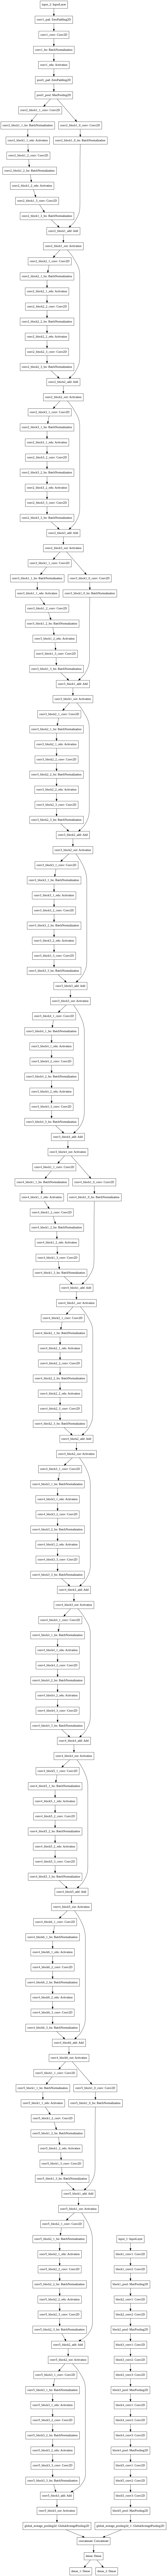

In [0]:
import tensorflow as tf

tf.keras.utils.plot_model(
    finalmodel, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
# train_imgen = ImageDataGenerator(rescale = 1./255, 
#                                    shear_range = 0.2, 
#                                    zoom_range = 0.2,
#                                    rotation_range=5.,
#                                    horizontal_flip = True,
#                                    vertical_flip=True)

# test_imgen = ImageDataGenerator(rescale = 1./255)


# def generate_generator_multiple(generator,X1,X2,batch_size=6, img_height=300,img_width=300):
# # def generate_generator_multiple(generator,X1,X2,Y1,Y2,batch_size=6, img_height=300,img_width=300):
#     print(
#         X1.shape)
#     # genX1 = generator.flow(X1,Y1,batch_size = batch_size,shuffle=True,seed=7)
    
#     genX1 = generator.flow(X1,batch_size = batch_size,shuffle=True,seed=7)
#     # genX1 = generator.flow(X1,batch_size = batch_size,shuffle=True,seed=7)
#     # genX2 = generator.flow(X2,Y2,batch_size = batch_size,shuffle=True,seed=7)
#     genX2 = generator.flow(X2,batch_size = batch_size,shuffle=True,seed=7)
#     while True:
#             X1i = genX1.next()
#             # Y1i = genX1.next()
#             X2i = genX2.next()
#             # Y2i = genX2.next()
#             print(X1i.shape)
            
#             yield [X1i, X2i]  #Yield both images and their mutual label
            
            
# # train_generator=generate_generator_multiple(train_imgen,x_train,x_train,y_train,y_train,batch_size=batch_size,img_height=300,img_width=300)       
# train_generator=generate_generator_multiple(train_imgen,x_train,x_train,batch_size=batch_size,img_height=300,img_width=300)       
     
# # test_generator=generate_generator_multiple(test_imgen,x_valid,x_valid,y_valid,y_valid,batch_size=batch_size,img_height=300,img_width=300)              
# test_generator=generate_generator_multiple(test_imgen,x_valid,x_valid,batch_size=batch_size,img_height=300,img_width=300)              
          
# history=finalmodel.fit_generator(train_generator,
#                         steps_per_epoch=x_train.shape[0]/batch_size,
#                         epochs = epochs,
#                         validation_data = test_generator,
#                         validation_steps = x_valid.shape[0]/batch_size,
#                         use_multiprocessing=True,
#                         shuffle=False)

In [0]:
import pandas as pd
result = pd.DataFrame(history.history)
result

,loss,dense_1_loss,dense_2_loss,dense_1_acc,dense_2_acc
0,2.455421,0.848774,1.606647,0.56250,0.43750
1,1.444137,0.623820,0.820318,0.67500,0.55000
2,1.063663,0.466455,0.597209,0.77500,0.68750
3,0.908251,0.387687,0.520564,0.85000,0.76250
4,0.698481,0.302654,0.395827,0.88125,0.80000
5,0.599032,0.253609,0.345423,0.92500,0.85625
6,0.530077,0.228030,0.302047,0.93750,0.86250
7,0.449421,0.189632,0.259788,0.98125,0.90000
8,0.462884,0.211833,0.251052,0.92500,0.92500
9,0.391930,0.175323,0.216606,0.95625,0.91875


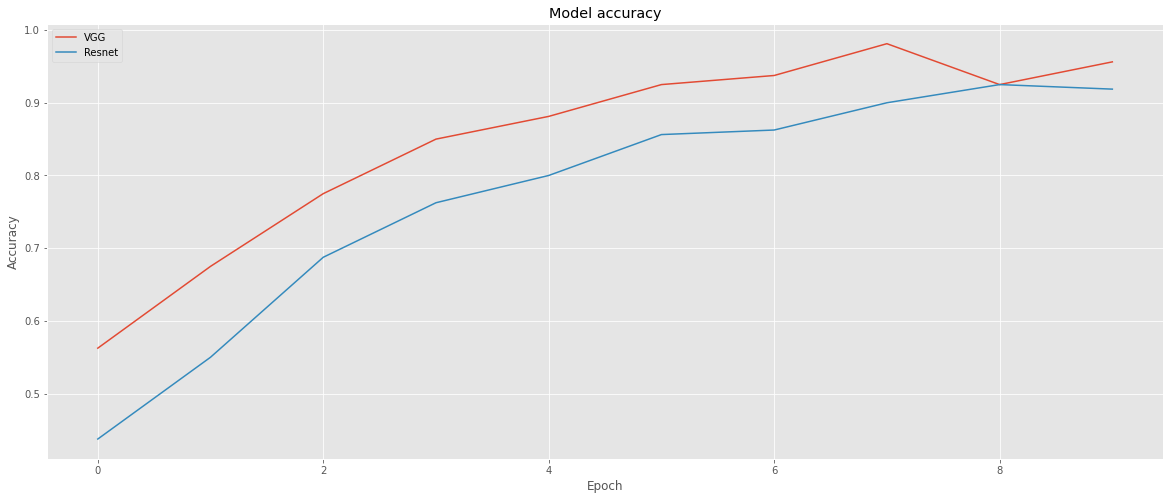

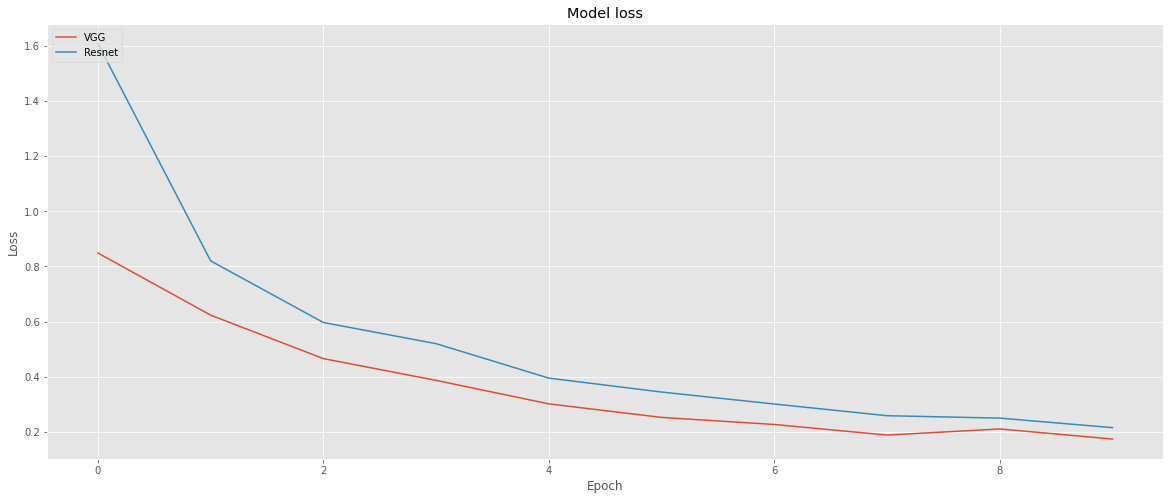

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

# Plot training & validation accuracy values
plt.figure(figsize=(20,8))
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['dense_2_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG', 'Resnet'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(20,8))
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['VGG', 'Resnet'], loc='upper left')
plt.show()

In [0]:
import datetime
result.to_csv(f"/content/drive/My Drive/dataset/result_{datetime.datetime.now()}.csv", index=False)

In [0]:
y_valid1 = np.asarray(y_valid).astype(np.float32).reshape((-1,2))
print(y_valid1.shape,y_valid.shape)

(18, 2) (18, 2)


In [0]:
x_test = np.array(x_test, np.float32)
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape, x_test.shape

((160, 300, 300, 3), (160, 2), (18, 300, 300, 3), (18, 2), (0,))

In [0]:
print('\n# Evaluate on test data')
results = finalmodel.evaluate([x_valid,x_valid], [y_valid,y_valid], batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
18/18 [==============================] - 2s 109ms/sample - loss: 1.0258 - dense_1_loss: 0.6448 - dense_2_loss: 0.3811 - dense_1_acc: 0.6111 - dense_2_acc: 0.7778
test loss, test acc: [1.025846242904663, 0.64476514, 0.38108107, 0.6111111, 0.7777778]


In [0]:
import os
covid = os.listdir('/content/drive/My Drive/dataset/test/COVID-19')
covid

['1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'covid-19-pneumonia-15-PA.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'B2D20576-00B7-4519-A415-72DE29C90C34.jpeg',
 '1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg',
 '8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg',
 '1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 '6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg',
 '9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg']

In [0]:
# ------ TESTING ------
x_test = []
for f in tqdm(covid, miniters=100):
    img = cv2.imread('/content/drive/My Drive/dataset/test/COVID-19/{}'.format(f))
    x_test.append(cv2.resize(img, (dim, dim)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

(10, 300, 300, 3)


In [0]:
if os.path.isfile(weights):
    finalmodel.load_weights(weights)

In [0]:
y_pred1,y_pred2 = finalmodel.predict([x_valid,x_valid], verbose=1)
p_test = finalmodel.predict([x_test,x_test], verbose=1)

10/10 [==============================] - 0s 10ms/sample


In [0]:
y_pred1,y_pred2 = np.argmax(y_pred1, axis=1), np.argmax(y_pred2, axis=1)

Text(0.5, 0, 'prediction VGG= pneumonia\nprediction RESNET= corona')

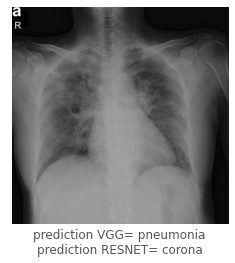

In [0]:
test_img=cv2.imread('/content/drive/My Drive/dataset/test/COVID-19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', True)
predlabel = list(label_map.keys())[list(label_map.values()).index(np.argmax(p_test[0][1]))]
predlabel1 = list(label_map.keys())[list(label_map.values()).index(np.argmax(p_test[1][1]))]
plt.imshow(test_img,cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction VGG= %s\nprediction RESNET= %s' % (predlabel,predlabel1), fontsize=12)

In [0]:
# p_test[0].shape
y_pred1 = np.array(y_pred1, dtype=np.int16)

In [0]:
y_valid = np.array(y_valid, dtype=np.int16)

In [0]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print('Classification Report VGG')
target_names = ['pneumonia', 'corona']
print(classification_report(y_pred1, y_valid))
print("Precision score: {}".format(precision_score(y_pred1, y_valid)))
print("Recall score: {}".format(recall_score(y_pred1, y_valid)))
print("F1 Score: {}".format(f1_score(y_pred1, y_valid)))

Classification Report VGG
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        16
           1       0.00      0.00      0.00         2

    accuracy                           0.39        18
   macro avg       0.39      0.22      0.28        18
weighted avg       0.69      0.39      0.50        18

Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0


In [0]:
print("Precision score: {}".format(precision_score(y_pred1, y_valid)))
print("Recall score: {}".format(recall_score(y_pred1, y_valid)))
print("F1 Score: {}".format(f1_score(y_pred1, y_valid)))

Precision score: 0.0
Recall score: 0.0
F1 Score: 0.0
